<a href="https://colab.research.google.com/github/mwiesiolek/machine-learning-classifiers/blob/master/my-dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%pylab inline 

import tensorflow as tf
from tensorflow import keras

tf.enable_eager_execution()
tf.executing_eagerly() 

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.contrib.eager as tfe
from IPython import display

Populating the interactive namespace from numpy and matplotlib


In [0]:
def g_model(width = 28, height = 28, noise_dim = 100, batch_size = 256):  
  
  model = keras.Sequential([
    tf.layers.Dense(7*7*256, activation=tf.nn.leaky_relu, use_bias = False, input_shape=(noise_dim,)),
    tf.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Reshape((7, 7, 256)),

    tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    tf.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    tf.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    
    tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation = 'tanh'),
  ])
  
  return model

In [0]:
def d_model(width = 28, height = 28):   
  
  model = keras.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape = (width, height, 1)),
    tf.keras.layers.LeakyReLU(),
    tf.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.layers.Dropout(0.3),
    
    tf.keras.layers.Flatten(),
    tf.layers.Dense(1)
  ])

  return model

In [0]:
def g_loss(generated_output):
  shape = tf.shape(generated_output)
  return tf.losses.sigmoid_cross_entropy(tf.ones([shape[0], shape[1]]), generated_output)

In [0]:
def d_loss(real_output, generated_output):
  real_shape = tf.shape(real_output)
  real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.ones([real_shape[0], real_shape[1]]), logits = real_output)
  
  generated_shape = tf.shape(generated_output)
  generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.zeros([generated_shape[0], generated_shape[1]]), logits = generated_output)
  
  return real_loss + generated_loss

In [0]:
g_optimizer = tf.train.AdamOptimizer(1e-3)
d_optimizer = tf.train.AdamOptimizer(1e-3)

In [0]:
def normalize_with_moments(x, axes=[0, 1], epsilon=1e-8):
    mean, variance = tf.nn.moments(x, axes=axes)
    x_normed = (x - 127.5) / 127.5
    return x_normed

In [0]:
def load_real_data(batch_size = 100, shuffle_buffer_size = 1000, width = 28, height = 28):
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
  
  x_train = x_train.reshape(x_train.shape[0], width, height, 1).astype('float')
  x_test = x_test.reshape(x_test.shape[0], width, height, 1).astype('float32')
  
  x_train = tf.constant(x_train, dtype=float32)
  x_test = tf.constant(x_test, dtype=float32)
  
  x_train = normalize_with_moments(x = x_train)
  x_test = normalize_with_moments(x = x_test)
  
  y_train = tf.constant(y_train, dtype=float32)
  y_test = tf.constant(y_test, dtype=float32)
  
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(shuffle_buffer_size).batch(batch_size)
  test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(shuffle_buffer_size).batch(batch_size)
  
  return train_ds, test_ds

In [0]:
def generate_and_render_images(model, input, width, height):
  predictions = model(input, training = False)
  
  display.clear_output(wait=True)
  
  # (16, 784)
  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(tf.reshape(predictions[i], [width, height]), cmap = 'gray')
    plt.axis('off')
    
  plt.show()

In [0]:
def train_step(batch_size, noise_dim, data, disc_model, gen_model):
    noise = tf.random_normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = gen_model(noise, training = True)

      real_output = disc_model(data, training = True)
      generated_output = disc_model(generated_images, training = True)

      gen_loss = g_loss(generated_output)
      disc_loss = d_loss(real_output, generated_output)
    
    g_gradients = gen_tape.gradient(gen_loss, gen_model.variables)
    d_gradients = disc_tape.gradient(disc_loss, disc_model.variables)
    
    g_optimizer.apply_gradients(zip(g_gradients, gen_model.variables))
    d_optimizer.apply_gradients(zip(d_gradients, disc_model.variables))

In [0]:
train_step = tf.contrib.eager.defun(train_step)

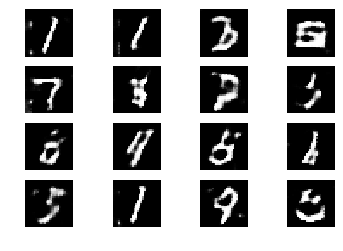

Time taken for epoch 50 is 24.288371562957764 sec
CPU times: user 4min 34s, sys: 1min 34s, total: 6min 9s
Wall time: 20min 24s


In [0]:
%%time

noise_dim = 100
batch_size = 1000
number_of_samples = 60000
steps = number_of_samples / batch_size
steps = tf.constant(steps, dtype=int32)
num_epochs = 50

width = 28
height = 28

# 60 000 * [28, 28]
train_ds, test_ds = load_real_data(batch_size = batch_size, shuffle_buffer_size = number_of_samples)

disc_model = d_model(width, height)
gen_model = g_model(width, height, noise_dim, batch_size)

random_vector_for_generation = tf.random_normal([16, noise_dim])

for epoch in range(num_epochs):
  start = time.time()

  for real_data in train_ds:
    train_step(batch_size, noise_dim, real_data[0], disc_model, gen_model)
    
  generate_and_render_images(gen_model, random_vector_for_generation, width, height)
  print ('Time taken for epoch {} is {} sec'.format(epoch + 1, time.time()-start))